### 12.2.3　数値結果

Warning message:
"package 'dlm' was built under R version 3.6.3"

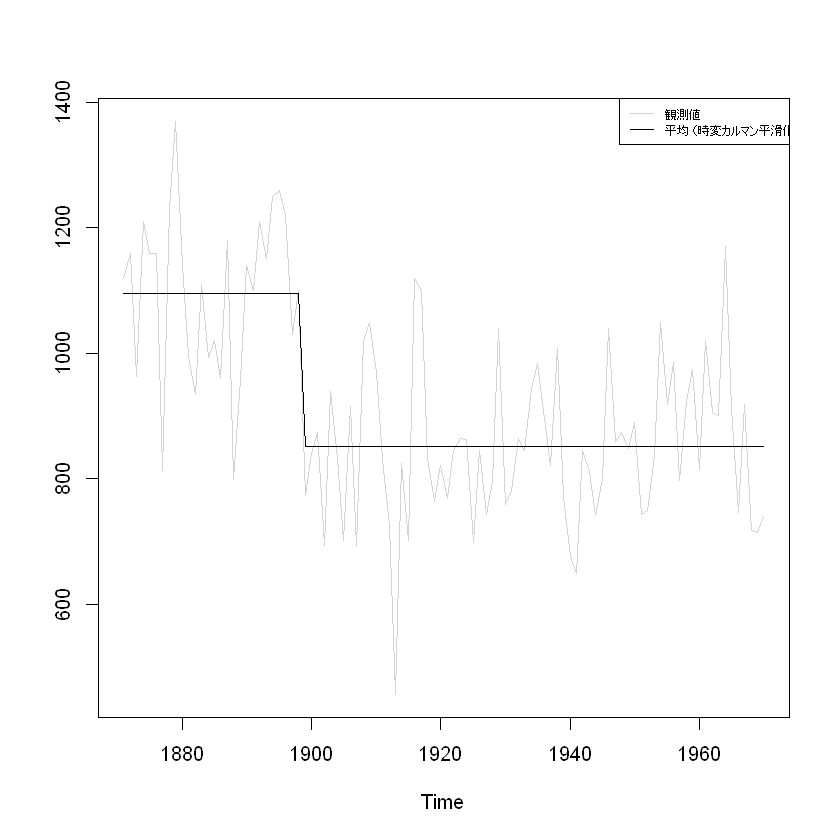

In [1]:
#【ナイル川の流量データにローカルレベルモデルを適用（時変カルマンフィルタ）】

# 前処理
set.seed(123)
library(dlm)

# ナイル川の流量データ
y <- Nile
t_max <- length(y)

# ローカルレベルモデルを構築する関数（状態雑音の分散が時変）
build_dlm <- function(par) {
  tmp <- dlmModPoly(order = 1, dV = exp(par[1]))

  # 状態雑音の分散はXの1列目を参照する
  tmp$JW <- matrix(1, nrow = 1, ncol = 1)

  # Xの1列目に状態雑音の分散を格納する
  tmp$X <- matrix(exp(par[2]), nrow = t_max, ncol = 1)

  # 1899年の状態雑音のみ増加を許容
  j <- which(time(y) == 1899)
  tmp$X[j, 1] <- tmp$X[j, 1] * exp(par[3])

  return(tmp)
}

# パラメータの最尤推定
fit_dlm <- dlmMLE(y = y, parm = rep(0, 3), build = build_dlm)
modtv <- build_dlm(fit_dlm$par)

# カルマン平滑化
dlmSmoothed_obj <- dlmSmooth(y = y, mod = modtv)

# 平滑化分布の平均
stv <- dropFirst(dlmSmoothed_obj$s)

# プロット
ts.plot(cbind(y, stv),
        lty=c("solid", "solid"),
        col=c("lightgray", "black"))

# 凡例
legend(legend = c("観測値", "平均 （時変カルマン平滑化)"),
       lty = c("solid", "solid"),
       col = c("lightgray", "black"),
       x = "topright", cex = 0.6)

まず，ユーザ定義関数 `build_dlm()` で時変のモデルを構築する．  
この関数の中では，関数 `dlmModPoly()` を使ってモデルのテンプレート `tmp` を作る．  
時変の状態雑音の分散を考慮するため，`tmp$JW` に1 (1×1 の行列) を設定する．  
時変の状態雑音の分散の具体的な値は `tmp$X` の1 列目に格納されることになるため，一旦全時点にベースとなる時不変の値を一律に設定している．  
その中でも1899年だけに正の倍率がかかるように，`tmp$X` の値を書き換えている．  

このようにして作成したモデル構築関数 `build_dlm()` を用いて，パラメータを最尤推定する．